In [ ]:
#install libraries
!pip install regressors -U
plt.rcParams['figure.figsize'] = [10, 5]

In [1]:
#01 - Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from datetime import datetime
import csv
import datetime as dt
from datetime import date
from collections import Counter
from regressors import stats

#### Load Plant 1 data
 Load the plant data and weather data sourced from Solar Plant 01 in a single dataframe

In [2]:
#02 - Load Plant 1 Data
plant_1 = pd.read_csv("C:\SparkCourse\SolarProject\Plant_1_Generation_Data.csv",\
                      quoting=csv.QUOTE_NONE, error_bad_lines=False)
#Load Weather data of plant 1
weather_1 = pd.read_csv('C:\SparkCourse\SolarProject\Plant_1_Weather_Sensor_Data.csv', \
                      quoting=csv.QUOTE_NONE, error_bad_lines=False)


#Change data type for date time    
plant_1['DATE_TIME'] = plant_1['DATE_TIME'].apply(lambda x: dt.date.strftime(dt.datetime.strptime(x, '%d-%m-%Y %H:%M')\
                                                                            , "%m/%d/%Y %H:%M"))
weather_1['DATE_TIME'] = weather_1['DATE_TIME'].apply\
(lambda x: dt.date.strftime(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), "%m/%d/%Y %H:%M"))


#Merge Plant and Weather data
plant_data = plant_1.merge(weather_1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATE_TIME']],\
                      how = 'left',
                      left_on=['DATE_TIME'],\
                     right_on = ['DATE_TIME'])
plant_data['DATE_TIME'] = plant_data['DATE_TIME'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y %H:%M'))
plant_data['TIME'] = plant_data['DATE_TIME'].apply(lambda x: str(x.hour)+str(x.minute))

#### Initial Data Analysis 

In [3]:
#01 - Stats
plant_data.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04,68774.000000,68774.000000,68774.000000
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06,25.558521,31.244997,0.232305
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05,3.361300,12.308283,0.301948
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06,20.398505,18.140415,0.000000
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06,22.724491,21.123944,0.000000
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06,24.670178,24.818984,0.031620
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06,27.960429,41.693659,0.454880
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06,35.252486,65.545714,1.221652


By going through the stats of each variable. we can identify the following:
1. 25% of all the records have not generated any DC_POWER.<br>
2. 25% of all the records have no irradiation. This shows there is no power generated in the night. 

In [7]:
test_df = plant_data.copy()

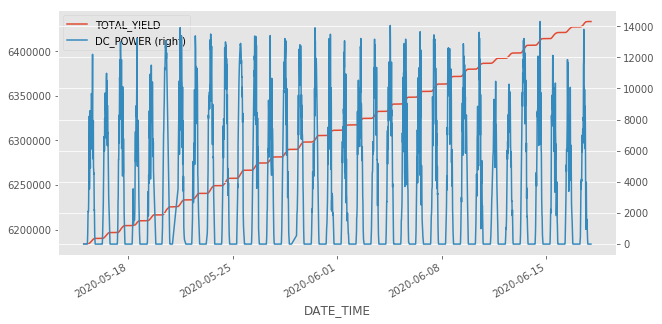

In [35]:
#04 - Compare total yield to DC_power
test = test_df[(test_df['SOURCE_KEY']=='1IF53ai7Xc0U56Y')]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
test.plot(x = 'DATE_TIME', y = 'TOTAL_YIELD', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'end_time', y = 'irrad', ax = ax)
test.plot(x = 'DATE_TIME', y = 'DC_POWER', ax = ax, secondary_y = True) 

The TOTAL_YIELD is defined as the total yield for the inverter till that point in time.<br> In the above graph, we can see gradual increase of TOTAL_YIELD over time.<br>
The Oscillations of DC_POWER is due to morning to evening change, causing power generated to change<br><br>
As we can still see records having DC POWER as zero.<br>
Lets clean the data to get yield generated per minute with a helper function.

In [9]:
#03 - Data Cleaning Functions
def CompressData(dataframe):
    dc_ind = False
    one_ind = False
    data = []
    for row in dataframe.itertuples():
        if int(row.DC_POWER) == 0:
            if dc_ind is False:
                plant_id = row.PLANT_ID
                source_key = row.SOURCE_KEY
                dc_pow = row.DC_POWER
                ac_pow = row.AC_POWER
                tot_yld = row.TOTAL_YIELD
                start_time = row.DATE_TIME
                amb_temp = row.AMBIENT_TEMPERATURE
                mod_temp = row.MODULE_TEMPERATURE
                irrad = row.IRRADIATION
                dc_ind = True
            else:
                end_time = row.DATE_TIME
                minutes_diff = (end_time - start_time).total_seconds() / 60.0
                tots = row.TOTAL_YIELD
                yld_diff = tots - tot_yld
                dc_pow = (row.DC_POWER + dc_pow)/2
                ac_pow = (row.AC_POWER + ac_pow)/2
                mod_temp = (row.MODULE_TEMPERATURE +mod_temp)/2
                amb_temp = (row.AMBIENT_TEMPERATURE +amb_temp)/2
                irrad = (row.IRRADIATION + irrad)/2
                one_ind = True
                
                pass
        else:
            if dc_ind is True:
                if one_ind is True:
                    try:
                        data.append([plant_id, source_key, start_time, end_time, minutes_diff, dc_pow, \
                                 ac_pow, tots, yld_diff, amb_temp, mod_temp, irrad])
                        del end_time, minutes_diff, tots, yld_diff
                        one_ind = False
                    except Exception as e:
                        print("one", e, row)
                else:
                    try:
                        data.append([plant_id, source_key, data[-1][3], start_time, \
                                 (start_time - data[-1][3]).total_seconds() / 60.0 ,\
                                 dc_pow, ac_pow, tot_yld, (tot_yld-data[-1][7]), amb_temp, \
                                 mod_temp, irrad])
                    except Exception as e:
                        print("two",e, row)
                    
                try:
                    data.append([row.PLANT_ID, row.SOURCE_KEY, data[-1][3], row.DATE_TIME,\
                         (row.DATE_TIME - data[-1][3]).total_seconds() / 60.0, row.DC_POWER, row.AC_POWER,\
                             row.TOTAL_YIELD, row.TOTAL_YIELD - data[-1][7], row.AMBIENT_TEMPERATURE, \
                             row.MODULE_TEMPERATURE, row.IRRADIATION])
                    dc_ind = False
                except Exception as e:
                    print("three",e, row)
            else:
                try:
                    start_time = data[-1][3]
                except Exception as e:
                    print("special", data, e, row)
                minutes_diff = (row.DATE_TIME - start_time).total_seconds() / 60.0
                tot_yld = data[-1][7]
                yld_diff = row.TOTAL_YIELD-tot_yld
                try:
                    data.append([row.PLANT_ID, row.SOURCE_KEY, start_time, row.DATE_TIME, minutes_diff, \
                             row.DC_POWER, row.AC_POWER, row.TOTAL_YIELD, yld_diff, row.AMBIENT_TEMPERATURE, \
                             row.MODULE_TEMPERATURE, row.IRRADIATION])
                except Exception as e:
                    print("four",e, row)
    return data

#### Data Cleaning

In [10]:
#01 - Call the Cleaning function for each Inverter
Final_df = pd.DataFrame(columns=['plant_id', 'source_key', 'start_time', 'end_time',\
                                   'minutes', 'dc_pow', 'ac_pow', 'total_yield', 'yield_generated'\
                                ,'amb_temp', 'mod_temp', 'irrad'])
for i in set(test_df.SOURCE_KEY):
    dfs = test_df[test_df['SOURCE_KEY']== i]
    dfs.reset_index(drop=True)
    temp_df = pd.DataFrame(data=CompressData(dfs), columns= Final_df.columns)
    Final_df = Final_df.append(temp_df)

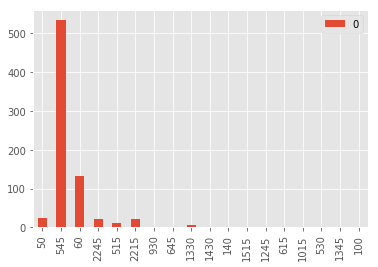

In [14]:
#Check time when DC_POWER is zero
Final_df['timestamp'] = Final_df['end_time'].apply(lambda x: str(x.hour)+str(x.minute))
a = list(Final_df[Final_df['dc_pow']==0].timestamp)
letter_counts = Counter(a)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df1 = df.head(60)
df1.plot(kind='bar')


In [16]:
#Delete records with TIME as 5:45
no_power_df = Final_df[Final_df['timestamp']=='545']
#Remove them from the test_df
Final_df = pd.concat([Final_df, no_power_df, no_power_df]).drop_duplicates(keep=False)
Final_df = Final_df.reset_index(drop = True)

Lets calculate yield generated per minute. this can be a measure to predict.<br> Building a model to predict yield per minute can be then used to predict the power generated.

In [18]:
#Add a new dimension as Yield Per Minute
Final_df['ypm'] = (Final_df['yield_generated']*1.00)/Final_df['minutes']
Final_df['effic'] = ((Final_df['ac_pow']/Final_df['dc_pow'])*100.0).fillna(0)
Final_df['datestamp'] = Final_df['end_time'].apply(lambda x: dt.datetime.strftime(x, '%Y%m%d'))


In [19]:
Final_df[Final_df.isna().any(axis = 1)]

,plant_id,source_key,start_time,end_time,minutes,dc_pow,ac_pow,total_yield,yield_generated,amb_temp,mod_temp,irrad,timestamp,ypm,effic,datestamp
26214,4135001,1IF53ai7Xc0U56Y,2020-06-03 13:45:00,2020-06-03 14:00:00,15.0,7003.0,685.8,6330385.0,511.0,NaN,NaN,NaN,140,34.066667,9.792946,20200603
29591,4135001,wCURE6d3bPkepu2,2020-06-03 13:45:00,2020-06-03 14:00:00,15.0,7545.0,738.7,6928448.0,516.5,NaN,NaN,NaN,140,34.433333,9.790590,20200603
32963,4135001,z9Y9gH1T5YWrNuG,2020-06-03 13:45:00,2020-06-03 14:00:00,15.0,7946.0,777.8,7152815.0,507.0,NaN,NaN,NaN,140,33.800000,9.788573,20200603
36327,4135001,adLQvlD726eNBSB,2020-06-03 13:45:00,2020-06-03 14:00:00,15.0,7204.0,705.4,6419961.0,522.0,NaN,NaN,NaN,140,34.800000,9.791782,20200603


There are nulls in the weather data. As the temperature taken 15 minutes is available, we can fill the nulls with preceeding values.

In [20]:
Final_df.irrad.fillna(method='ffill', inplace=True)
Final_df.mod_temp.fillna(method='ffill', inplace=True)
Final_df.amb_temp.fillna(method='ffill', inplace=True)

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


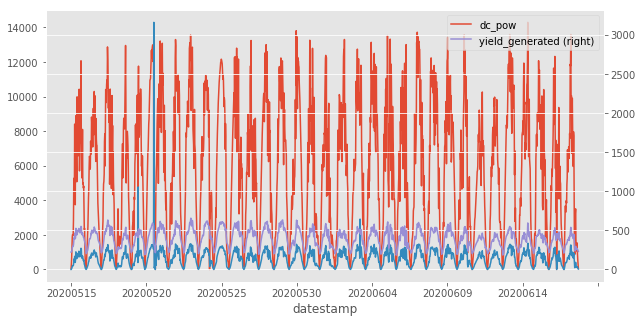

In [36]:
test = Final_df[(Final_df['source_key']=='zBIq5rxdHJRwDNY')]
fig, ax = plt.subplots() # Create the figure and axes object
test['dtemp'] = test['mod_temp']*10

# Plot the first x and y axes:
test.plot(x = 'datestamp', y = 'dc_pow', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'end_time', y = 'irrad', ax = ax)
test.plot(x = 'datestamp', y = 'yield_generated', ax = ax, secondary_y = True) 
test.plot(x = 'datestamp', y = 'dtemp', ax = ax, secondary_y = True) 

we see similar ups and downs for dc_power to yield_generated to module temp with minor outliers

In [28]:
#OneHotEncoding for inverters
dummies = pd.get_dummies(Final_df.source_key, drop_first=True)
Solar_plant_1 = pd.concat([Final_df, dummies], axis = 'columns')
Solar_plant_1
del Solar_plant_1['source_key']
Solar_plant_1 = Solar_plant_1.reset_index(drop=True)

#Prep data for building model
yld_gen = Solar_plant_1['ypm']
data = Solar_plant_1.copy()
del data['ypm']
del data['plant_id'], data['start_time'], data['end_time'], data['minutes'], data['total_yield'], data['timestamp'], data['datestamp'], data['yield_generated']


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
#Split data
X_train, X_test, Y_train, Y_test = train_test_split(data, yld_gen, test_size = 0.3)

#Build Model
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred.shape

(11117,)

In [31]:
from sklearn.metrics import mean_squared_error, r2_score
print("Coefficients:  ", model.coef_)
print("Intercept:  ", model.intercept_)
print("MSE:  %.2f" % mean_squared_error(Y_test, Y_pred))
print("Coefficients of determination:  %.2f" % r2_score(Y_test, Y_pred))

print("\n=========== SUMMARY ===========")
xlabels = X_test.columns
stats.summary(model, X_test, Y_test, xlabels)

Coefficients:   [-4.88858080e-03  6.08631910e-02 -2.94529382e-01  3.74360216e-01
 -5.02509814e+00  2.80888672e-02  2.53868885e-01  2.50510993e-01
  1.75975235e-01  2.76127004e-01  2.51705051e-01  1.90306335e-01
  1.84713354e-01  2.72748825e-01  1.72518834e-01  3.39250452e-01
 -9.47109523e-02  2.24262151e-01  1.70406219e-01  2.04410237e-01
  2.25330830e-01  2.14894621e-01  2.18544723e-01  2.30141885e-01
  1.89297887e-01  1.83234449e-01  2.25946952e-01]
Intercept:   -1.7414836527603157
MSE:  1.44
Coefficients of determination:  0.96

=========== SUMMARY ===========
Residuals:
    Min     1Q  Median      3Q      Max
-21.615 -0.577  0.0062  0.4887  10.3722


Coefficients:
                 Estimate  Std. Error   t value   p value
_intercept      -1.741484    0.180326   -9.6574  0.000000
dc_pow          -0.004889    0.000074  -66.3570  0.000000
ac_pow           0.060863    0.007565    8.0449  0.000000
amb_temp        -0.294529    0.004412  -66.7494  0.000000
mod_temp         0.374360    0.00

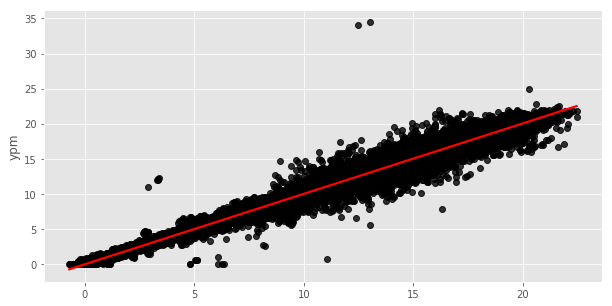

In [37]:
sns.regplot(x=Y_pred, y=Y_test, scatter_kws={"color": "black"}, line_kws={"color": "red"})

## Solar Generation Plant 2 Analysis

In [38]:
#Source Plant 2 data
plant_2 = pd.read_csv("C:\SparkCourse\SolarProject\Plant_2_Generation_Data.csv",\
                      quoting=csv.QUOTE_NONE, error_bad_lines=False)
#Load Weather data of plant 2
weather_2 = pd.read_csv('C:\SparkCourse\SolarProject\Plant_2_Weather_Sensor_Data.csv', \
                      quoting=csv.QUOTE_NONE, error_bad_lines=False)


#Change data type for date time    
plant_2['DATE_TIME'] = plant_2['DATE_TIME'].apply(lambda x: dt.date.strftime(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')\
                                                                            , "%m/%d/%Y %H:%M"))
weather_2['DATE_TIME'] = weather_2['DATE_TIME'].apply\
(lambda x: dt.date.strftime(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), "%m/%d/%Y %H:%M"))


#Merge Plant and Weather data
plant_data2 = plant_2.merge(weather_2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATE_TIME']],\
                      how = 'left',
                      left_on=['DATE_TIME'],\
                     right_on = ['DATE_TIME'])
plant_data2['DATE_TIME'] = plant_data2['DATE_TIME'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y %H:%M'))
plant_data2['TIME'] = plant_data2['DATE_TIME'].apply(lambda x: str(x.hour)+str(x.minute))

In [41]:
plant_data2.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04,67698.000000,67698.000000,67698.000000
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08,27.986756,32.607233,0.229204
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08,4.021294,11.226446,0.309365
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00,20.942385,20.265123,0.000000
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07,24.570349,23.685627,0.000000
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08,26.910352,27.433723,0.018554
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09,30.912601,40.019036,0.431027
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09,39.181638,66.635953,1.098766


By going through the stats of each variable. we can identify the following:
1. 50% of all the records have not generated any DC_POWER.<br>
2. 25% of all the records have no irradiation. This shows there is no power generated in the night. 

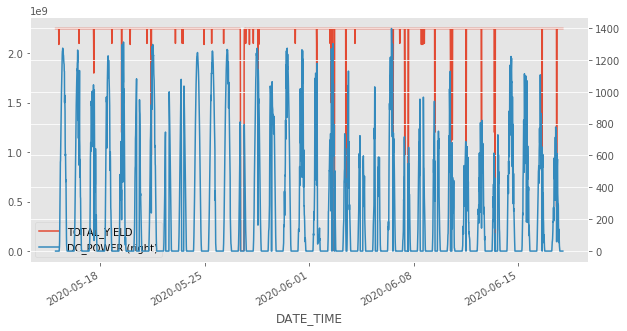

In [42]:
test_df2 = plant_data2.copy()

test = test_df2[(test_df2['SOURCE_KEY']=='9kRcWv60rDACzjR')]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
test.plot(x = 'DATE_TIME', y = 'TOTAL_YIELD', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'end_time', y = 'irrad', ax = ax)
test.plot(x = 'DATE_TIME', y = 'DC_POWER', ax = ax, secondary_y = True) 

This looks like TOTAL YIELD is not gradually increasing over time period. There are records with a decrease in total yield

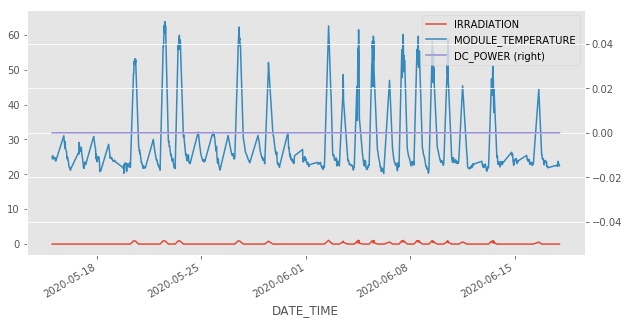

In [43]:
test = test_df2[(test_df2['SOURCE_KEY']=='9kRcWv60rDACzjR')&(test_df2['DC_POWER']==0)]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
test.plot(x = 'DATE_TIME', y = 'IRRADIATION', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
test.plot(x = 'DATE_TIME', y = 'MODULE_TEMPERATURE', ax = ax)
test.plot(x = 'DATE_TIME', y = 'DC_POWER', ax = ax, secondary_y = True) 

The irradiation is zero or low in most of the data points where dc_power is zero. But there are data points where the irradiation levels are high but no power was generated. This could be inverter issues or error caused while recording data
<br>
We still see differences in data. As per the definition of TOTAL_YIELD. we are assuming the TOTAL_YIELD is gradually increasing or same over time. let us separate the records where there is a drop in TOTAL_YIELD for each inverter

In [47]:
data = []
dumps = []
d2 = []
for j in set(test_df2.SOURCE_KEY):
    dfs = test_df2[test_df2['SOURCE_KEY']== j]
    dfs.reset_index(drop=True)
    ind = 0
    
    for i in dfs.itertuples():
        if ind ==0:
            data.append([i.DATE_TIME, i.PLANT_ID, i.SOURCE_KEY, i.DC_POWER, i.AC_POWER, i.DAILY_YIELD,\
                     i.TOTAL_YIELD, i.AMBIENT_TEMPERATURE, i.MODULE_TEMPERATURE, i.IRRADIATION, i.TIME])
            ind +=1
        else:
            if i.TOTAL_YIELD>=data[-1][6]:
                data.append([i.DATE_TIME, i.PLANT_ID, i.SOURCE_KEY, i.DC_POWER, i.AC_POWER, i.DAILY_YIELD,\
                     i.TOTAL_YIELD, i.AMBIENT_TEMPERATURE, i.MODULE_TEMPERATURE, i.IRRADIATION, i.TIME])
            elif dumps:
                if i.TOTAL_YIELD <= dumps[-1][6]:
                    d2.append([i.DATE_TIME, i.PLANT_ID, i.SOURCE_KEY, i.DC_POWER, i.AC_POWER, i.DAILY_YIELD,\
                     i.TOTAL_YIELD, i.AMBIENT_TEMPERATURE, i.MODULE_TEMPERATURE, i.IRRADIATION, i.TIME])
            else:
                dumps.append([i.DATE_TIME, i.PLANT_ID, i.SOURCE_KEY, i.DC_POWER, i.AC_POWER, i.DAILY_YIELD,\
                     i.TOTAL_YIELD, i.AMBIENT_TEMPERATURE, i.MODULE_TEMPERATURE, i.IRRADIATION, i.TIME])
dump_df = pd.DataFrame(data=dumps, columns= test_df2.columns)
data_df = pd.DataFrame(data=data, columns= test_df2.columns)
d2_df = pd.DataFrame(data=d2, columns= test_df2.columns)

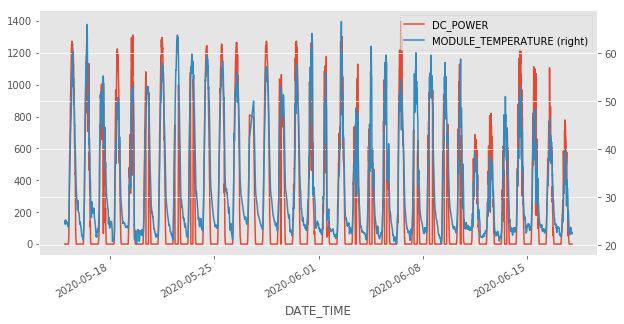

In [48]:
test = data_df[(data_df['SOURCE_KEY']=='9kRcWv60rDACzjR')]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
#test.plot(x = 'DATE_TIME', y = 'IRRADIATION', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)

test.plot(x = 'DATE_TIME', y = 'DC_POWER', ax = ax)
test.plot(x = 'DATE_TIME', y = 'MODULE_TEMPERATURE', ax = ax, secondary_y = True) 

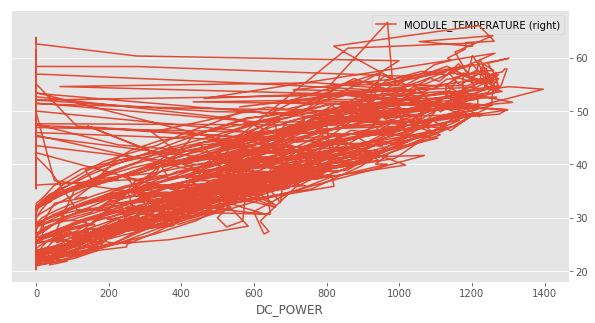

In [49]:
test = data_df[(data_df['SOURCE_KEY']=='9kRcWv60rDACzjR')]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
#test.plot(x = 'DATE_TIME', y = 'IRRADIATION', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'DATE_TIME', y = 'MODULE_TEMPERATURE', ax = ax)
test.plot(x = 'DC_POWER', y = 'MODULE_TEMPERATURE', ax = ax, secondary_y = True) 

We can see some records having high module temp but have not produced and power. <br>As we can see a correlation between Module Temperature and DC_Power. We can remove the records which have module temp > 37(50percentile) and have not produced any power

In [58]:
no_dc2 = data_df[(data_df['MODULE_TEMPERATURE']>38) &(data_df['DC_POWER']==0)]
data_df = pd.concat([data_df, no_dc2, no_dc2]).drop_duplicates(keep = False)
data_df = data_df.reset_index(drop=True)

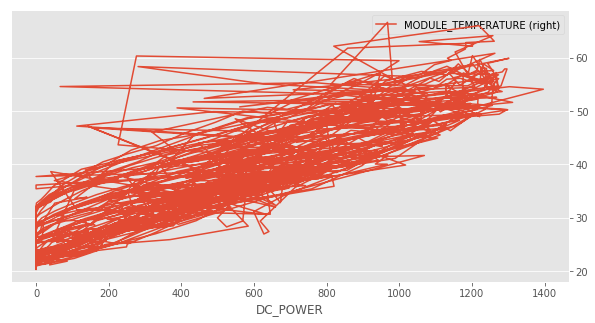

In [59]:
test = data_df[(data_df['SOURCE_KEY']=='9kRcWv60rDACzjR')]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
#test.plot(x = 'DATE_TIME', y = 'IRRADIATION', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'DATE_TIME', y = 'MODULE_TEMPERATURE', ax = ax)
test.plot(x = 'DC_POWER', y = 'MODULE_TEMPERATURE', ax = ax, secondary_y = True) 

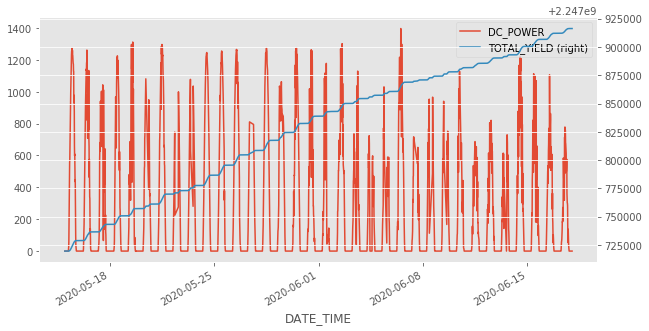

In [60]:
test = data_df[(data_df['SOURCE_KEY']=='9kRcWv60rDACzjR')]
fig, ax = plt.subplots() # Create the figure and axes object
# Plot the first x and y axes:
test.plot(x = 'DATE_TIME', y = 'DC_POWER', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'end_time', y = 'irrad', ax = ax)
test.plot(x = 'DATE_TIME', y = 'TOTAL_YIELD', ax = ax, secondary_y = True) 
#test.plot(x = 'DATE_TIME', y = 'MODULE_TEMPERATURE', ax = ax, secondary_y = True) 

In [61]:
#04 - Call the Cleaning function for each Inverter
Final_df2 = pd.DataFrame(columns=['plant_id', 'source_key', 'start_time', 'end_time',\
                                   'minutes', 'dc_pow', 'ac_pow', 'total_yield', 'yield_generated'\
                                ,'amb_temp', 'mod_temp', 'irrad'])
for i in set(data_df.SOURCE_KEY):
    dfs = data_df[data_df['SOURCE_KEY']== i]
    dfs.reset_index(drop=True)
    temp_df = pd.DataFrame(data=CompressData(dfs), columns= Final_df2.columns)
    Final_df2 = Final_df2.append(temp_df)

In [80]:
#Add a new dimension as Yield Per Minute
Final_df2['ypm'] = (Final_df2['yield_generated']*1.00)/Final_df2['minutes']
Final_df2['effic'] = ((Final_df2['ac_pow']/Final_df2['dc_pow'])*100.0).fillna(0)
Final_df2['datestamp'] = Final_df2['end_time'].apply(lambda x: dt.datetime.strftime(x, '%Y%m%d'))
Final_df2[Final_df2.isna().any(axis = 1)]

,plant_id,source_key,start_time,end_time,minutes,dc_pow,ac_pow,total_yield,yield_generated,amb_temp,mod_temp,irrad,ypm,datestamp,time,effic


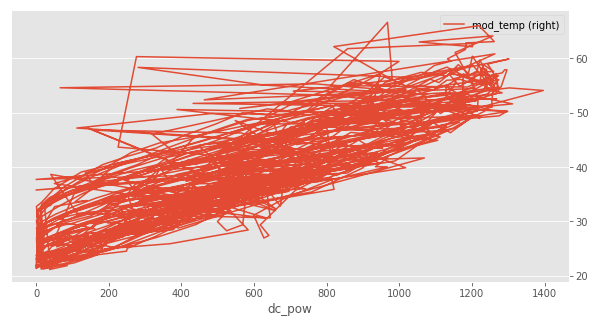

In [81]:
test = Final_df2[(Final_df2['source_key']=='9kRcWv60rDACzjR')]
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
#test.plot(x = 'DATE_TIME', y = 'IRRADIATION', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
#test.plot(x = 'DATE_TIME', y = 'MODULE_TEMPERATURE', ax = ax)
test.plot(x = 'dc_pow', y = 'mod_temp', ax = ax, secondary_y = True) 

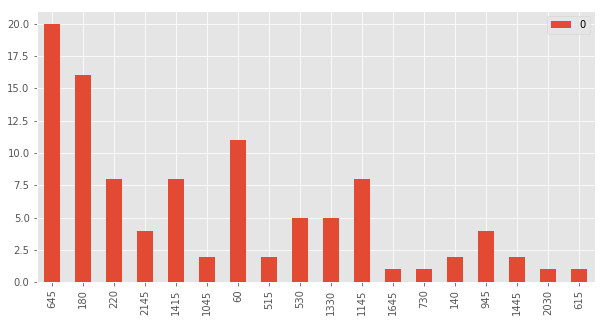

In [82]:
#Verify if there is any records with 0 dc_power
Final_df2['time'] = Final_df2['end_time'].apply(lambda x: str(x.hour)+str(x.minute))

a = list(Final_df2[Final_df2['dc_pow']==0].time)
letter_counts = Counter(a)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df1 = df.head(60)
df.plot(kind='bar')

In [83]:
#Delete records with TIME as 4:45
no_power_df2 = Final_df2[Final_df2['time']=='545']
#Remove them from the test_df
Final_df2 = pd.concat([Final_df2, no_power_df2, no_power_df2]).drop_duplicates(keep=False)
Final_df2 = Final_df2.reset_index(drop = True)

In [84]:
#OneHotEncoding for inverters
dummies2 = pd.get_dummies(Final_df2.source_key, drop_first=True)
Solar_plant_2 = pd.concat([Final_df2, dummies2], axis = 'columns')
Solar_plant_2
del Solar_plant_2['source_key']
Solar_plant_2 = Solar_plant_2.reset_index(drop=True)

#Prep data for building model
yld_gen2 = Solar_plant_2['ypm']
data2 = Solar_plant_2.copy()
del data2['ypm']
del data2['plant_id'], data2['start_time'], data2['end_time'], data2['minutes'], data2['total_yield'], data2['time'], data2['datestamp'], data2['yield_generated']


In [87]:
#Split data
X2_train, X2_test, Y2_train, Y2_test = train_test_split(data2, yld_gen2, test_size = 0.3)

#Build Model
model2 = linear_model.LinearRegression()
model2.fit(X2_train, Y2_train)
Y2_pred = model2.predict(X2_test)
Y2_pred.shape

(9311,)

In [88]:
from sklearn.metrics import mean_squared_error, r2_score
print("Coefficients:  ", model2.coef_)
print("Intercept:  ", model2.intercept_)
print("MSE:  %.2f" % mean_squared_error(Y2_test, Y2_pred))
print("Coefficients of determination:  %.2f" % r2_score(Y2_test, Y2_pred))

# to print summary table:
print("\n=========== SUMMARY ===========")
xlabels = X2_test.columns
stats.summary(model2, X2_test, Y2_test, xlabels)

Coefficients:   [-8.17377250e-02  9.79163584e-02 -1.53969863e-01  2.25770121e-01
 -3.97427925e+00 -1.28875989e-04  7.17287953e-04  4.31978103e-02
 -2.77361233e-01  8.19015116e-02 -9.07998868e-02 -4.19199971e-02
  1.66605485e-02  7.03908497e-02 -6.37630793e-02  5.83194585e-03
 -3.59582736e-01  2.56529053e-02  1.28526126e-01  7.86963006e-02
  3.70362274e-02  1.96257218e-02 -1.19020788e-01 -1.14555553e-01
  7.24295014e-02  1.06724346e-01 -1.92647784e-02]
Intercept:   -1.4388778062644345
MSE:  2.51
Coefficients of determination:  0.94

=========== SUMMARY ===========
Residuals:
     Min      1Q  Median      3Q      Max
-15.3197 -0.5464 -0.0144  0.3586  15.8228


Coefficients:
                 Estimate  Std. Error  t value   p value
_intercept      -1.438878    0.295463  -4.8699  0.000001
dc_pow          -0.081738    0.008950  -9.1331  0.000000
ac_pow           0.097916    0.009373  10.4466  0.000000
amb_temp        -0.153970    0.007667 -20.0813  0.000000
mod_temp         0.225770    0.005

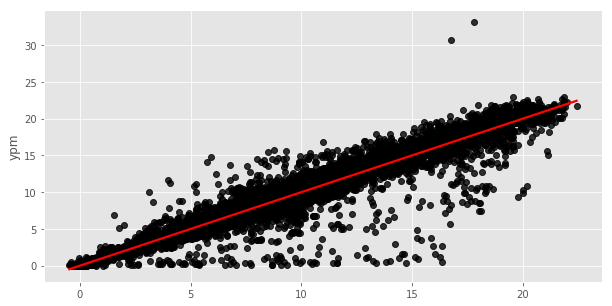

In [89]:
sns.regplot(x=Y2_pred, y=Y2_test, scatter_kws={"color": "black"}, line_kws={"color": "red"})